In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

import incense
from incense import ExperimentLoader
import pandas as pd

import sys
sys.path.append('../')

from experiments import sacred_auth_details

In [2]:
loader = ExperimentLoader(mongo_uri=sacred_auth_details.db_url, db_name='safe-exploration')

## Recent all experiments

In [27]:
exps_by_time = loader.find({
    '$query':{
        '$or':[{'status': 'COMPLETED'}, {'status': 'RUNNING'},]}, 
    '$orderby':{'start_time':-1}})
exps_by_time.project(on=['host.hostname', 'command', 'start_time', 'status', 'config.cem_ssm', 
                         'config.mpc_time_horizon', 
                         'config.mc_dropout_hidden_features'])[0:10]

,hostname,command,start_time,status,cem_ssm,mpc_time_horizon,mc_dropout_hidden_features
exp_id,,,,,,,
150,Oscars-MacBook-Pro.local,main,2019-07-15 16:52:21.074,RUNNING,mc_dropout,2,"[64, 64]"
142,oscar-1,main,2019-07-15 16:34:31.451,COMPLETED,exact_gp,2,"[64, 64]"
141,oscar-1,main,2019-07-15 16:04:53.035,COMPLETED,exact_gp,2,"[64, 64]"
140,oscar-1,main,2019-07-15 16:03:59.751,COMPLETED,exact_gp,2,"[64, 64]"
137,oscar-1,main,2019-07-15 16:03:53.098,COMPLETED,exact_gp,2,"[64, 64]"
138,oscar-1,main,2019-07-15 16:03:53.083,COMPLETED,exact_gp,2,"[64, 64]"
136,oscar-1,main,2019-07-15 15:33:19.982,COMPLETED,exact_gp,2,"[64, 64]"
135,oscar-1,main,2019-07-15 15:16:32.977,COMPLETED,exact_gp,2,"[64, 64]"
134,oscar-1,main,2019-07-15 15:00:11.954,COMPLETED,exact_gp,2,"[64, 64]"


## Recent main experiments

In [78]:
exps_by_time = loader.find({
    '$query':{
        '$or':[{'status': 'COMPLETED'}, {'status': 'RUNNING'},],
        'command': 'main'}, 
    '$orderby':{'start_time':-1}})
exps_by_time.project(on=['host.hostname', 'start_time', 'status', 'config.cem_ssm', 'config.mpc_time_horizon', 
                         'config.n_ep'])[0:10]

,hostname,start_time,status,cem_ssm,mpc_time_horizon,n_ep
exp_id,,,,,,
168,Oscars-MacBook-Pro.local,2019-07-16 10:28:08.521,RUNNING,mc_dropout,2,8
167,oscar-1,2019-07-16 09:10:14.886,COMPLETED,exact_gp,2,8
166,oscar-1,2019-07-16 09:10:04.341,COMPLETED,exact_gp,2,8
165,oscar-1,2019-07-16 09:09:54.373,COMPLETED,exact_gp,2,8
163,oscar-1,2019-07-16 09:09:46.987,COMPLETED,exact_gp,2,8
158,oscar-1,2019-07-16 00:36:12.020,COMPLETED,mc_dropout_gal,2,8
157,oscar-1,2019-07-15 21:34:26.691,COMPLETED,mc_dropout_gal,2,8
155,oscar-1,2019-07-15 20:08:57.295,COMPLETED,exact_gp,2,8
154,oscar-1,2019-07-15 20:05:11.418,COMPLETED,exact_gp,2,8


## Experiment details

In [79]:
exps = loader.find_by_ids([163, 165, 166, 167])

# Make sure all experiments have values for all config keys.
config_keys = set()
for exp in exps:
    config_keys.update(exp.config.keys())

for exp in exps:
    for key in config_keys:
        if key not in exp.config.keys():
            exp.config[key] = '?'
            
# Duplicate all metrics so we can use it multiple times in projections.
for exp in exps:
    exp.info['all_metrics2'] = exp.info.all_metrics

def failure_rate(metrics):
    all_lengths = list(itertools.chain.from_iterable(metrics['episode_length'].values()))
    total_steps = sum(all_lengths)
    failures = len(all_lengths) - all_lengths.count(50)
    percent = failures / total_steps * 100
    return f'{failures}/{total_steps} ({percent:.2f}%)'

def fallback_rate(metrics):
    total_steps = sum(itertools.chain.from_iterable(metrics['episode_length'].values()))
    fallback_steps = sum(itertools.chain.from_iterable(metrics['safe_controller_fallback_count'].values()))
    percent = fallback_steps / total_steps * 100
    return f'{fallback_steps}/{total_steps} ({percent:.2f}%)'

frame = exps.project(on=['config.cem_ssm', 
                         'config.mc_dropout_hidden_features', 
                         'config.mc_dropout_training_iterations',
                         'config.mc_dropout_type',
                         'config.cem_beta_safety',
                         'config.use_prior_model',
                         {'info.all_metrics': failure_rate},
                         {'info.all_metrics2': fallback_rate}])
frame = frame.sort_values(['mc_dropout_hidden_features'])
frame.columns = map(lambda name: name.replace('mc_dropout', 'mcd'), frame.columns)
frame.columns = map(lambda name: name.replace('all_metrics', ''), frame.columns)
frame

,cem_ssm,mcd_hidden_features,mcd_training_iterations,mcd_type,cem_beta_safety,use_prior_model,_failure_rate,2_fallback_rate
exp_id,,,,,,,,
163,exact_gp,"[64, 64]",2001,concrete,0.5,True,0/2400 (0.00%),157/2400 (6.54%)
165,exact_gp,"[64, 64]",2001,concrete,2.0,True,0/2400 (0.00%),2400/2400 (100.00%)
166,exact_gp,"[64, 64]",2001,concrete,3.0,True,0/2400 (0.00%),2400/2400 (100.00%)
167,exact_gp,"[64, 64]",2001,concrete,1.0,True,0/2400 (0.00%),2400/2400 (100.00%)


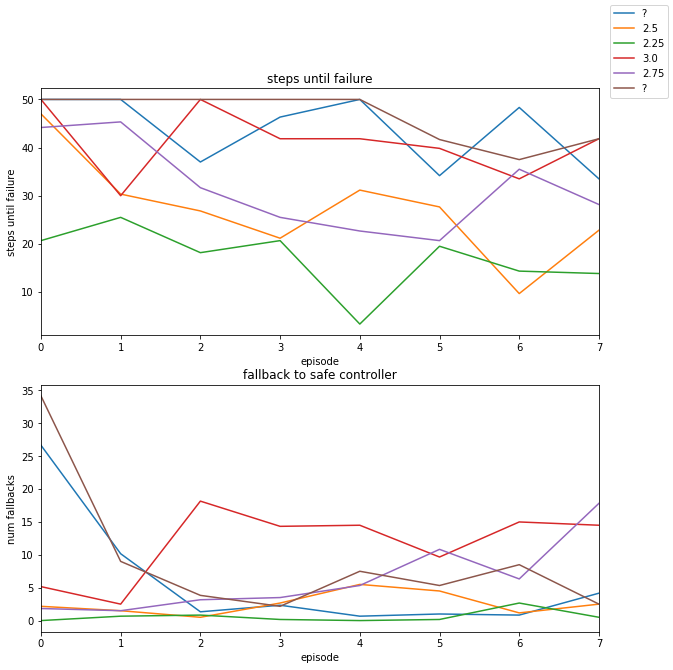

In [32]:
def get_label(exp):
    c = defaultdict(lambda: '?', exp.config)
    return c['cem_beta_safety']

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for exp in exps:
    label = get_label(exp)
    exp.metrics['episode_length'].plot(ax=axes[0], label=label)
    exp.metrics['safe_controller_fallback_count'].plot(ax=axes[1], label='')
    
axes[0].set_ylabel('steps until failure')
axes[0].set_xlabel('episode')
axes[0].set_title('steps until failure')

axes[1].set_ylabel('num fallbacks')
axes[1].set_xlabel('episode')
axes[1].set_title('fallback to safe controller')

fig.legend()

### Time in solver

In [81]:
# Should log this as metric, but in advance retrieve from text logs.
def get_times_in_solver(exp, mean=True):
    # state: 0=wait for episode id, 1=wait for end of episode
    state = 0
    current_episode = -1
    current_scenario = -1
    total_time_sum = 0.
    results = defaultdict(lambda: {})
    for i, line in enumerate(exp.captured_out.split('\n')):
        if line.startswith('Starting episode'):
            if state != 0:
                raise ValueError(f'line {i}')
            out_of = [x for x in line.split(' ') if '/' in x]
            assert len(out_of) == 2
            current_episode = int(out_of[0].split('/')[0])
            current_scenario = int(out_of[1].split('/')[0])
            state = 1

        if line.startswith('total time solver'):
            if state != 1:
                raise ValueError
            total_time_sum += float(line.split(': ')[1])

        if line.startswith('Agent survived'):
            if state != 1:
                raise ValueError
            parts = line.split(' ')
            total_steps = float(parts[2])
            results[current_episode][current_scenario] = total_time_sum / total_steps
            total_time_sum = 0.
            state = 0
    
    if mean:
        results = {k: sum(v.values())/len(v.values()) for k, v in results.items()}
    
    return results
        
print(get_times_in_solver(loader.find_by_id(140)))
print('')
print(get_times_in_solver(loader.find_by_id(163)))

{1: 0.18705353339513142, 2: 0.20704497763088772, 3: 0.2260822280248006, 4: 0.6014388449986776, 5: 0.7076372234026591, 6: 0.8188964250992085, 7: 0.8617143408781818, 8: 0.8915225847562155}

{1: 0.8111427100499471, 2: 0.8370879364013671, 3: 0.9530709044138591, 4: 2.246869009335836, 5: 2.3897081732749936, 6: 1.9833342440923054, 7: 2.035462390581767, 8: 2.0599818801879883}


## Failed episode dropout investigation

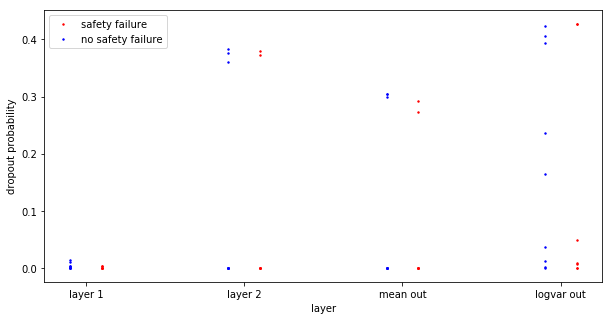

In [82]:
def map_name(name):
    if name == 'dropout_p_conc_drop1':
        return 'layer 1'
    if name == 'dropout_p_conc_drop2':
        return 'layer 2'
    if name == 'dropout_p_conc_drop_logvar':
        return 'logvar out'
    if name == 'dropout_p_conc_drop_mu':
        return 'mean out'
    return name

exp = loader.find_by_id(121)
dropout_metrics = {map_name(k): v for k,v in exp.info.all_metrics.items() if k.startswith('dropout_p')}
failed_episodes = [(1, 0), (1,1), (0,3), (0,5), (1,5), (0,6), (1,6)]

# Compare average p on non-failures, to value of p during failures

success_labels = []
success_data = []
failure_labels = []
failure_data = []

for metric_name, metric_data in dropout_metrics.items():
    for episode in range(len(metric_data)):
        episode_key = f'json://{episode}'
        for scenario in range(len(metric_data[episode_key])):
            if (scenario, episode) in failed_episodes:
                failure_labels.append(metric_name)
                failure_data.append(metric_data[episode_key][scenario])
            else:
                success_labels.append(metric_name)
                success_data.append(metric_data[episode_key][scenario])
                
label_vals = {
    'layer 1': 1.,
    'layer 2': 2.,
    'mean out': 3.,
    'logvar out': 4.
}
success_labels = [label_vals[label] - 0.1 for label in success_labels]
failure_labels = [label_vals[label] + 0.1 for label in failure_labels]

plt.figure(figsize=(10,5))
plt.scatter(failure_labels, failure_data, color='red', s=2, label='safety failure')
plt.scatter(success_labels, success_data, color='blue', s=2, label='no safety failure')
plt.xticks(list(label_vals.values()), list(label_vals.keys()))
plt.xlabel('layer')
plt.ylabel('dropout probability')
plt.legend()
plt.show()

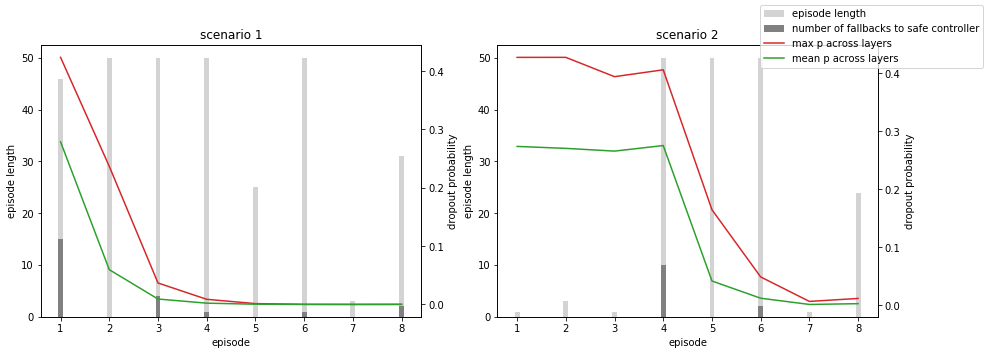

In [144]:
num_episodes = len(dropout_metrics['layer 1'])
num_scenarios = len(dropout_metrics['layer 1']['json://0'])
means = np.empty((num_scenarios, num_episodes))
maxes = np.empty((num_scenarios, num_episodes))
mins = np.empty((num_scenarios, num_episodes))
lengths = np.empty((num_scenarios, num_episodes))
fallbacks = np.empty((num_scenarios, num_episodes))
for episode in range(num_episodes):
    episode_key = f'json://{episode}'
    for scenario in range(num_scenarios):
        ps = [metric[episode_key][scenario] for metric in dropout_metrics.values()]
        mean = sum(ps) / len(ps)
        means[scenario, episode] = mean
        maxes[scenario, episode] = max(ps)
        mins[scenario, episode] = min(ps)
        
        lengths[scenario, episode] = exp.info.all_metrics.episode_length[episode_key][scenario]
        fallbacks[scenario, episode] = exp.info.all_metrics.safe_controller_fallback_count[episode_key][scenario]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
episodes = range(1, num_episodes + 1)

ax1.bar(episodes, lengths[0], width=0.1, color='lightgrey', label='episode length')
ax1.bar(episodes, fallbacks[0], width=0.1, color='grey', label='number of fallbacks to safe controller')
ax1.set_title('scenario 1')
ax1.set_ylabel('episode length')
ax1.set_xlabel('episode')
ax1b = ax1.twinx()
ax1b.plot(episodes, maxes[0], label='max p across layers', color='C3')
ax1b.plot(episodes, means[0], label='mean p across layers', color='C2')
ax1b.set_ylabel('dropout probability')

ax2.bar(episodes, lengths[1], width=0.1, color='lightgrey')
ax2.bar(episodes, fallbacks[1], width=0.1, color='grey')
ax2.set_title('scenario 2')
ax2.set_ylabel('episode length')
ax2.set_xlabel('episode')
ax2b = ax2.twinx()
ax2b.plot(episodes, maxes[1], label='', color='C3')
ax2b.plot(episodes, means[1], label='', color='C2')
ax2b.set_ylabel('dropout probability')
fig.legend()
plt.show()

In [126]:
exp.info.all_metrics

{'dropout_p_conc_drop1': {'json://0': [0.00310467349922007,
   0.0028719743824776],
  'json://1': [0.0010271246482141609, 0.00282722347056777],
  'json://2': [0.0003931340199839717, 0.010778975373347738],
  'json://3': [8.150025536235801e-05, 0.013866042989169646],
  'json://4': [0.00026974046814636415, 0.0031758604233917223],
  'json://5': [3.570346569948842e-05, 0.0007344035035435467],
  'json://6': [1.9636370474506463e-05, 9.43787573507709e-05],
  'json://7': [3.865122942112008e-05, 0.0002771958492704341]},
 'dropout_p_conc_drop2': {'json://0': [0.3841109521519621,
   0.37276340327891994],
  'json://1': [0.0005915645681577753, 0.379925603511623],
  'json://2': [6.856280711713596e-05, 0.3597392204468604],
  'json://3': [1.370938679188011e-05, 0.37683543992759594],
  'json://4': [4.92333380097849e-06, 0.0003352554214687274],
  'json://5': [4.244291198497268e-06, 5.061764214030536e-05],
  'json://6': [6.717160822148933e-06, 1.4194293633924108e-05],
  'json://7': [4.161429524280144e-06,